# Comparing address-level risk estimates for CONUS

This notebook compares address-level risk estimates from our dataset with those from the Wildfire Risk to Communities dataset (WRC, Scott et al., 2024). We calculate a set of comparison criteria to understand how our datasets are similar and different.

In [1]:
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import kendalltau

from ocr import catalog

warnings.filterwarnings('ignore')

In [2]:
def apply_kendall_tau(x, y):
    # we use the c variant here because the comparisons here have non-square contingency tables
    tau, p_value = kendalltau(x, y, variant='c')
    return pd.Series({'tau': tau, 'p_value': p_value})

In [3]:
def apply_bias(x, y):
    bias = np.mean(x - y)
    return pd.Series({'bias': bias})

In [4]:
def apply_median(x, label):
    median = np.median(x)
    return pd.Series({f'median_{label}': median})

In [5]:
def apply_mean(x, label):
    mean = np.mean(x)
    return pd.Series({f'mean_{label}': mean})

In [6]:
def fraction_zeros(x, y):
    x_fract_zero = (x == 0).sum() / len(x)
    y_fract_zero = (y == 0).sum() / len(y)
    return pd.Series({'x_fract_zero': x_fract_zero, 'y_fract_zero': y_fract_zero})

In [7]:
def apply_corr(x, y):
    corr = np.corrcoef(x, y)
    return pd.Series({'corr': corr[0, 1]})

In [8]:
states = gpd.read_file('s3://carbonplan-risks/shapefiles/cb_2018_us_state_20m.zip')
states = states[~(states['STUSPS'].isin(['AK', 'PR', 'HI']))]

In [9]:
census_tracts_df = (
    catalog.get_dataset('us-census-tracts')
    .query_geoparquet(
        "SELECT GEOID, NAME, ST_AsText(geometry) as geometry, bbox FROM read_parquet('{s3_path}')"
    )
    .df()
)
census_tracts = gpd.GeoDataFrame(
    census_tracts_df, geometry=gpd.GeoSeries.from_wkt(census_tracts_df['geometry'])
)
census_tracts.crs = 'EPSG:4326'  # add CRS because it is missing it and these are both EPSG 4326
census_tracts.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,GEOID,NAME,geometry,bbox
0,01063060102,601.02,"POLYGON ((-88.03501 32.83534, -88.03501 32.835...","{'xmin': -88.035013, 'ymin': 32.744738, 'xmax'..."
1,01063060101,601.01,"POLYGON ((-87.99829 32.76851, -87.99326 32.771...","{'xmin': -87.998289, 'ymin': 32.739319, 'xmax'..."
2,01069040802,408.02,"POLYGON ((-85.44941 31.15536, -85.44937 31.155...","{'xmin': -85.449475, 'ymin': 31.10551, 'xmax':..."
3,01069040204,402.04,"POLYGON ((-85.46063 31.25039, -85.4606 31.2506...","{'xmin': -85.46063, 'ymin': 31.225301, 'xmax':..."
4,01069041902,419.02,"POLYGON ((-85.30625 31.14305, -85.30624 31.143...","{'xmin': -85.306265, 'ymin': 31.058496, 'xmax'..."


Load in a parquet file describing risk for the 156 million buildings in the dataset. Each building carries a ~current day risk value from our dataset and from the WRC dataset. We calculate Kendall's Tau, bias, median, mean, and correlation to better understand how the datasets compare. While the dataset exists at a 30m resolution for the entirety of CONUS, the focus of our comparisons is in developed areas, so we focus on address-level buildings for this comparison.

In [12]:
%%time

# NOTE: if either of these are True you need to be on a machine with ~200GB memory. Also this will take about an hour and will
# look like there is nothing happening.
remake_building_tract_file = True
remake_tract_stats_file = True
version = '1.1.0'
if remake_building_tract_file:
    # NOTE: anything reading this file requires being on a machine with ~200GB memory
    building_file = gpd.read_parquet(
        f's3://carbonplan-ocr/output/fire-risk/vector/production/v{version}/geoparquet/consolidated-buildings.parquet'
    )
    building_file = building_file.drop(['bbox'], axis=1)
    # intersects will duplicate buildings that straddle multiple census tracts. we could clean this up
    # later by de-duplicating buildings
    buildings_in_census_tracts = gpd.sjoin(building_file, census_tracts[['GEOID', 'geometry']])
    buildings_in_census_tracts.to_parquet(
        f's3://carbonplan-ocr/evaluation/comparisons/buildings-tracts-geo-{version}.parquet'
    )
if remake_tract_stats_file:
    # NOTE: anything reading this file requires being on a machine with ~200GB memory
    if not remake_building_tract_file:
        buildings_in_census_tracts = gpd.read_parquet(
            f's3://carbonplan-ocr/evaluation/comparisons/buildings-tracts-geo-{version}.parquet'
        )
    census_tracts = census_tracts.rename({'GEOID': 'GEOID_right'}, axis=1)
    df_buildings_in_census_tracts = buildings_in_census_tracts[
        ['rps_scott', 'rps_2011', 'rps_2047', 'GEOID_right']
    ]
    tract_tau = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
        lambda g: apply_kendall_tau(g['rps_2011'], g['rps_scott'])
    )
    tract_performance_stats = census_tracts[['GEOID_right', 'geometry']].merge(
        tract_tau, on='GEOID_right'
    )
    # add what fraction of the buildings have zero risk because those tracts should be removed since tau is NaN
    new_df = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
        lambda g: fraction_zeros(g['rps_2011'], g['rps_scott'])
    )
    tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID_right')
    # add correlation calculation
    new_df = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
        lambda g: apply_corr(g['rps_2011'], g['rps_scott'])
    )
    tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID_right')
    # add bias calculation
    new_df = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
        lambda g: apply_bias(g['rps_2011'], g['rps_scott'])
    )
    tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID_right')
    # add mean calculation for both x and y
    for setup in ['rps_2011', 'rps_scott']:
        new_df = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
            lambda g: apply_mean(g[setup], setup)
        )
        tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID_right')
    # add median calculation for both x and y
    for setup in ['rps_2011', 'rps_scott']:
        new_df = df_buildings_in_census_tracts.groupby('GEOID_right').apply(
            lambda g: apply_median(g[setup], setup)
        )
        tract_performance_stats = tract_performance_stats.merge(new_df, on='GEOID_right')
    tract_performance_stats['normalized_bias'] = (
        tract_performance_stats['bias'] / tract_performance_stats['mean_rps_scott']
    )
    # filter out any places that are all zeros in either CP or USFS because they'll either make for NaN kendall tau or infinity in bias
    tract_performance_stats = tract_performance_stats[
        ~(tract_performance_stats['x_fract_zero'] == 1)
    ]
    tract_performance_stats = tract_performance_stats[
        ~(tract_performance_stats['y_fract_zero'] == 1)
    ]
    tract_performance_stats = tract_performance_stats.rename({'GEOID_right': 'GEOID'}, axis=1)
    tract_performance_stats.to_parquet(
        f's3://carbonplan-ocr/evaluation/comparisons/tracts-stats-geo-{version}.parquet'
    )
else:
    tract_performance_stats = gpd.read_parquet(
        f's3://carbonplan-ocr/evaluation/comparisons/tracts-stats-geo-{version}.parquet'
    )

CPU times: user 48min 31s, sys: 1min 7s, total: 49min 38s
Wall time: 49min 6s


In [13]:
variable_name_dict = {
    'tau': "Kendall's Tau of RPS",
    'bias': 'RPS bias (CP - Scott)',
    'corr': 'Correlation (CP vs. Scott)',
    'median_rps_2011': 'CP median RPS',
    'median_rps_scott': 'Scott median RPS',
    'mean_rps_2011': 'CP mean RPS',
    'mean_rps_scott': 'Scott mean RPS',
    'normalized_bias': 'RPS normalized bias\n((CP - Scott)/Scott)',
}
# limits to use for plotting the different performance metrics
var_lims = {'tau': [-1, 1], 'bias': [-0.1, 0.1], 'normalized_bias': [-1, 1], 'corr': [-1, 1]}

cmaps = {'tau': 'PRGn', 'bias': 'RdBu_r', 'normalized_bias': 'RdBu_r', 'corr': 'PRGn'}

## Visualizing risk from different datasets

Plotting the absolute values of the risk value helps us understand the distribution of risk within each dataset.

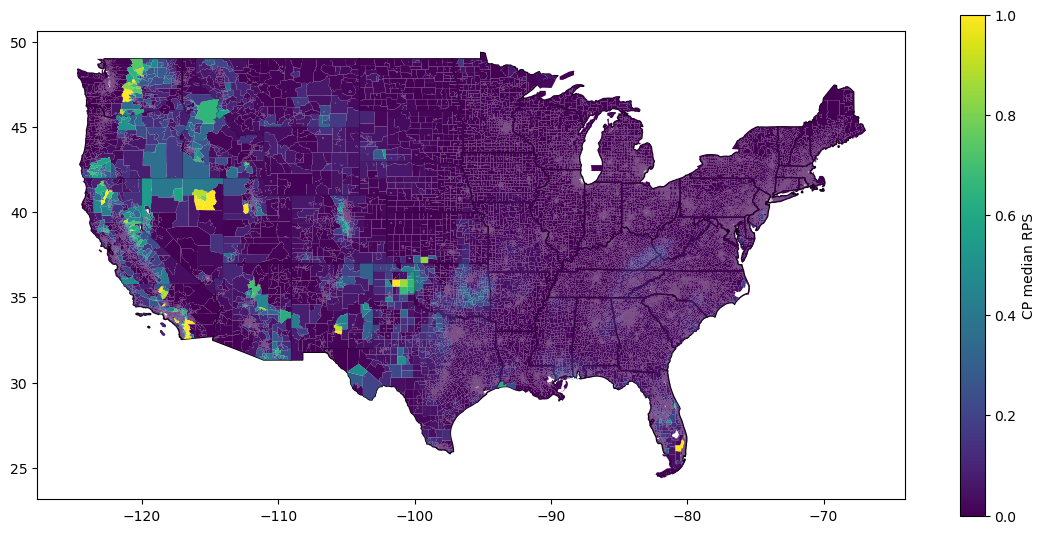

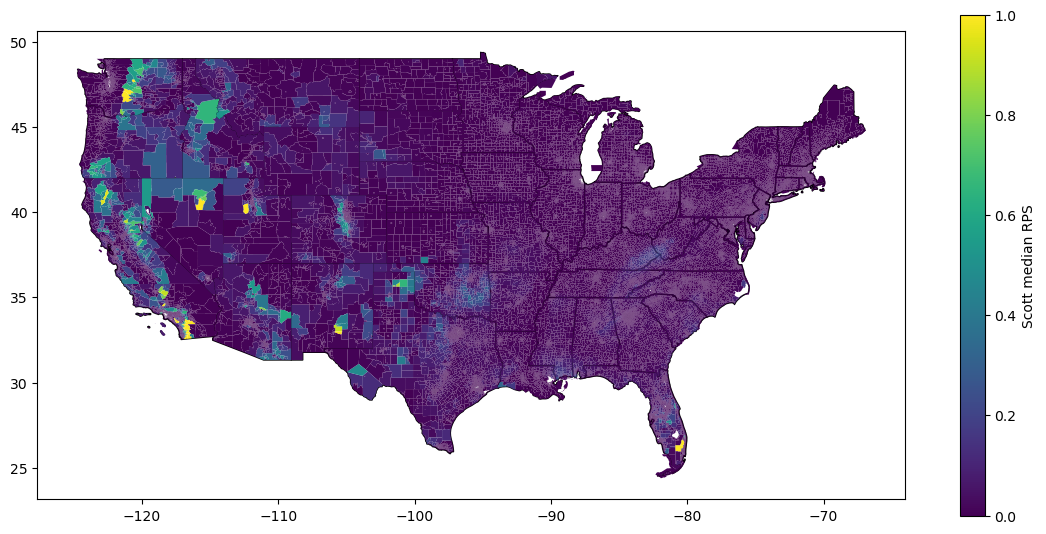

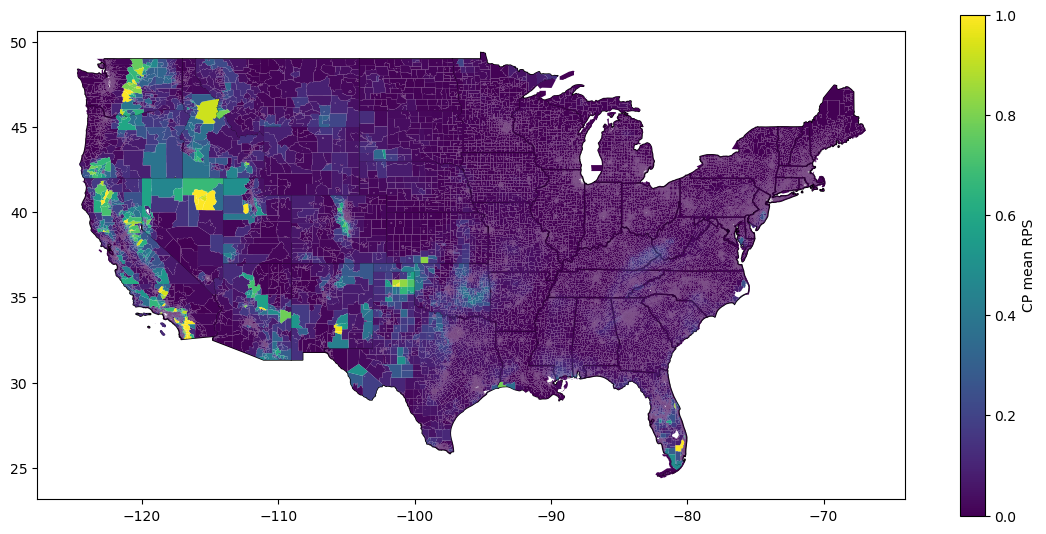

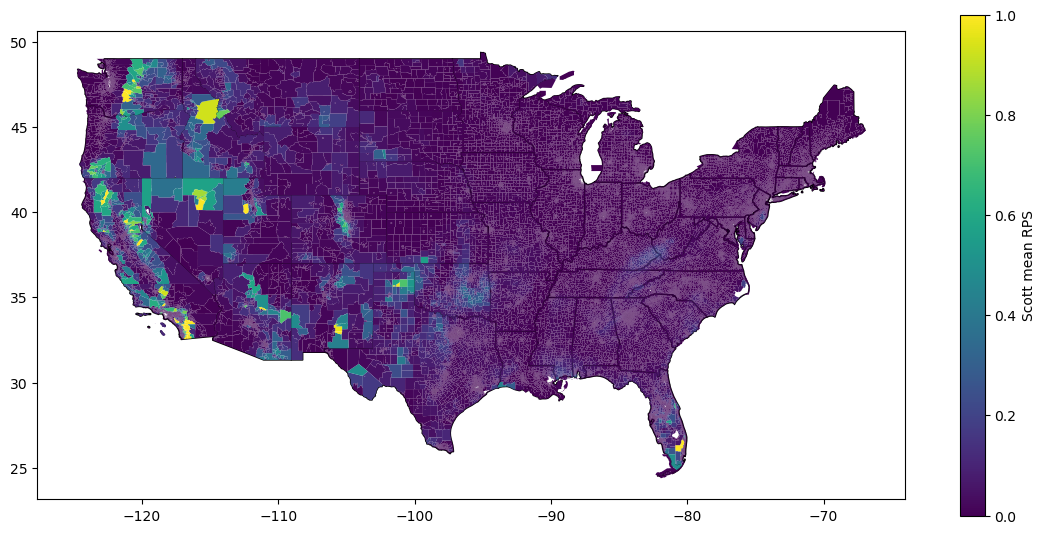

In [14]:
for variable in [
    'median_rps_2011',
    'median_rps_scott',
    'mean_rps_2011',
    'mean_rps_scott',
]:
    fig, axarr = plt.subplots(figsize=(14, 10))
    states.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=0,
        vmax=1,
        legend=True,
        cmap='viridis',
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )

## Calculating comparison statistics

We calculate average correlation but calculate median of bias and relative bias because small differences in areas of very low risk can result in very large bias values.

In [15]:
print(f'Average census-tract level correlation: {tract_performance_stats["corr"].mean()}')
print(f'Average census-tract level bias: {tract_performance_stats["bias"].median()}')
print(
    f'Average census-tract level normalized bias: {tract_performance_stats["normalized_bias"].median()}'
)

Average census-tract level correlation: 0.7886770791998363
Average census-tract level bias: 0.00019393349066376686
Average census-tract level normalized bias: 0.3505880534648895


We can map the performance statistics across all census tracts within CONUS. Areas in white were places where at least one of the two datasets labeled every building as having zero fire risk.

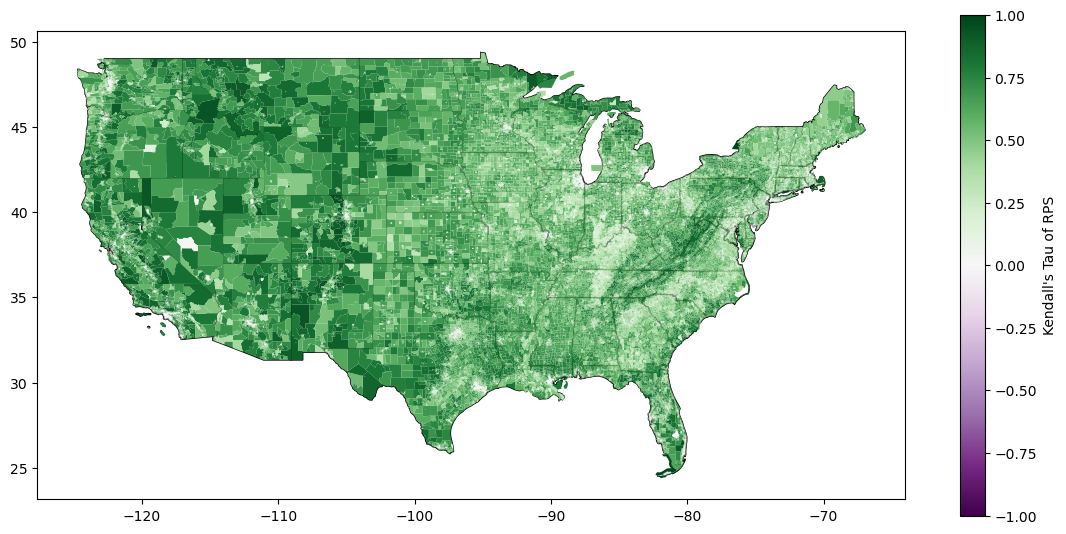

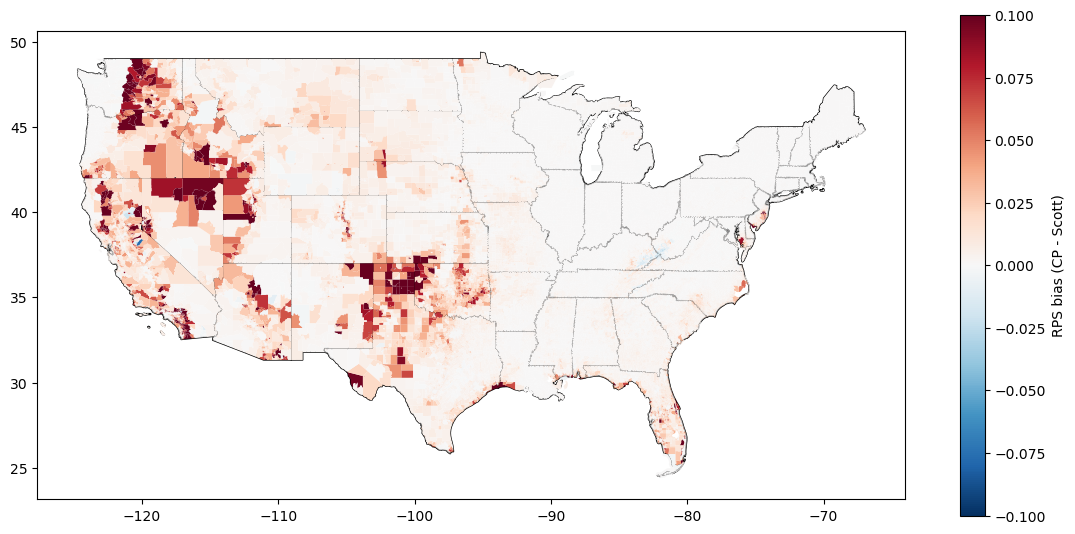

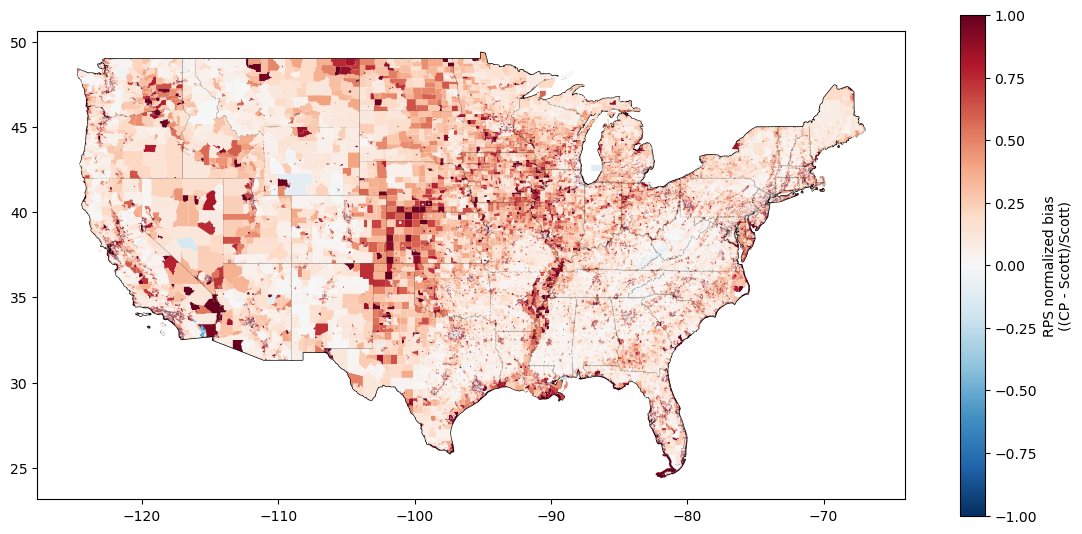

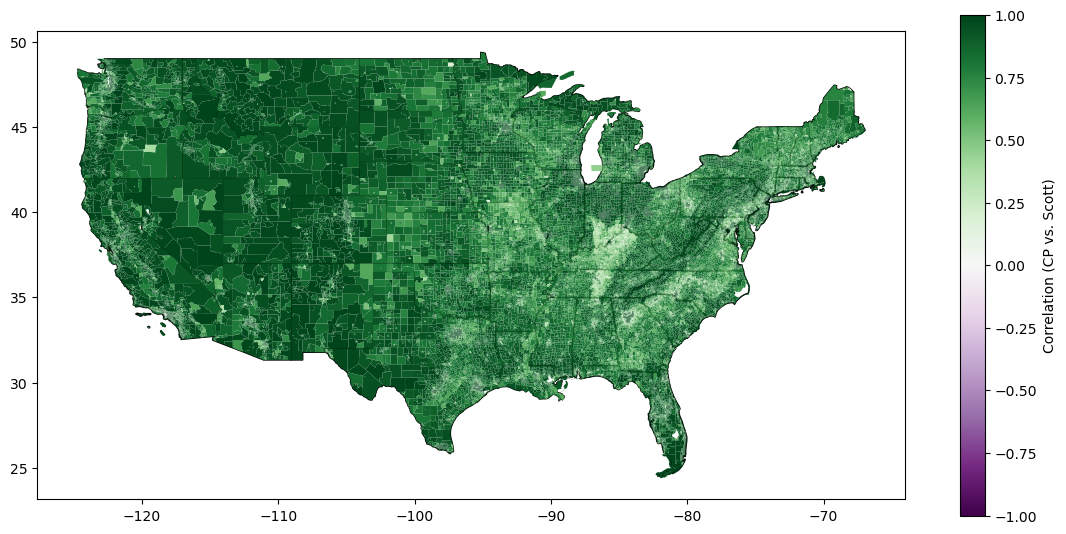

In [16]:
for variable in ['tau', 'bias', 'normalized_bias', 'corr']:
    fig, axarr = plt.subplots(figsize=(14, 10))
    states.plot(ax=axarr, color='white', edgecolor='black')
    ax = tract_performance_stats.plot(
        ax=axarr,
        column=variable,
        vmin=var_lims[variable][0],
        vmax=var_lims[variable][1],
        legend=True,
        cmap=cmaps[variable],
        legend_kwds={'shrink': 0.65, 'label': variable_name_dict[variable]},
    )

The maps above show us what the performance looks like spatially, but a choropleth plot can be misleading since each census tract has about the same number of buildings and so larger census tracts draw a disproportionate amount of attention to the eye. We can instead look at the entire distribution of performance statistics shown below. Note that the upper limit for the normalized bias is truncated.

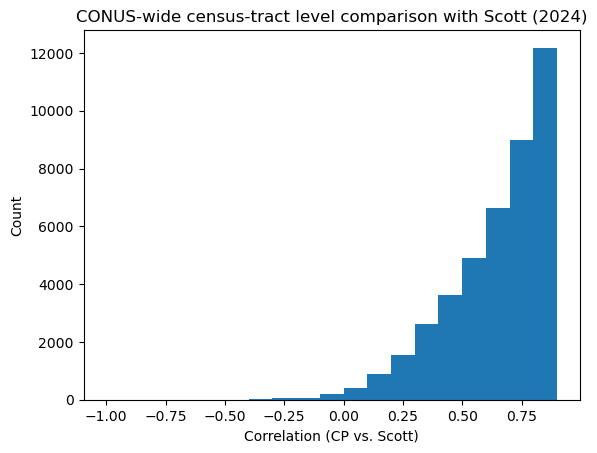

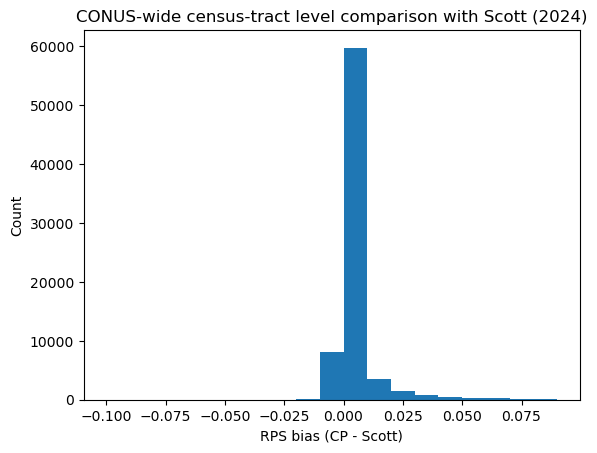

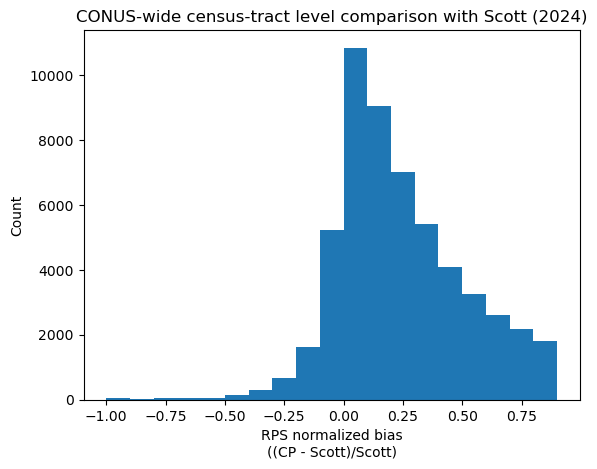

In [17]:
for statistic in ['corr', 'bias', 'normalized_bias']:
    plt.figure()
    plt.hist(
        tract_performance_stats[statistic].values,
        bins=np.arange(var_lims[statistic][0], var_lims[statistic][1], var_lims[statistic][1] / 10),
    )
    # plt.legend()
    plt.xlabel(variable_name_dict[statistic])
    plt.ylabel('Count')
    plt.title('CONUS-wide census-tract level comparison with Scott (2024)')

## Identifying hotspots of difference between the WRC and OCR data

Below we identify hotspots where our values are markedly different from those of the WRC project to plot individual regions spatially using the `compare-risk-rasters.ipynb` notebook. To identify places where our datasets differ most substantially, we must control for the fact that fire risk varies by orders of magnitude across CONUS which can create dramatically high (or low) absolute and relative biases in areas with very high (or low) risk. So, we identify tracts with _both_ high (or low) relative _and_ absolute risk.

In [18]:
def find_hotspots(quantile, tract_df, direction):
    hot_spot_thresholds = tract_df[['bias', 'normalized_bias']].quantile(quantile, axis=0)
    if direction == 'high':
        bias_filter = tract_df['bias'] > hot_spot_thresholds['bias']
        normalized_bias_filter = (
            tract_df['normalized_bias'] > hot_spot_thresholds['normalized_bias']
        )
    elif direction == 'low':
        bias_filter = tract_df['bias'] < hot_spot_thresholds['bias']
        normalized_bias_filter = (
            tract_df['normalized_bias'] < hot_spot_thresholds['normalized_bias']
        )
    return tract_df[bias_filter & normalized_bias_filter]

## Top 3 hot spot tracts where we overpredict w.r.t. WRC are all around LA

In [19]:
high_bias_hotspots = find_hotspots(0.98, tract_performance_stats, 'high')

<Axes: >

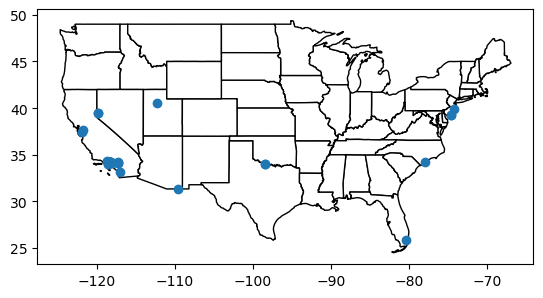

In [20]:
fig, axarr = plt.subplots()
states.plot(ax=axarr, color='white', edgecolor='black')
high_bias_hotspots.centroid.plot(ax=axarr)

Save out some of the hotspots for further detailed raster-level inspection in the `compare-risk-rasters.ipynb` notebook

In [21]:
high_bias_hotspots.to_file(f'high_bias_tracts_{version}.shp')

## Now look at low hotspots - places where we're saying low risk compared to WRC

In [22]:
low_bias_hotspots = find_hotspots(0.006, tract_performance_stats, 'low')

Save out some of the hotspots for further detailed raster-level inspection in the `compare-risk-rasters.ipynb` notebook

In [23]:
low_bias_hotspots.to_file(f'low_bias_tracts_{version}.shp')

<Axes: >

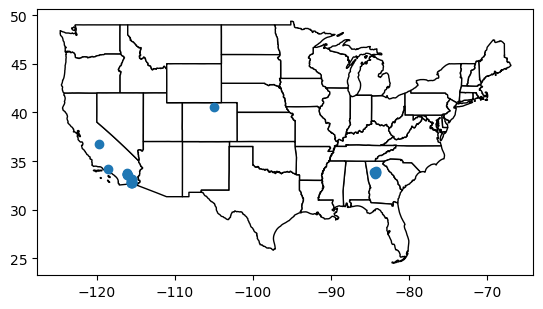

In [24]:
fig, axarr = plt.subplots()
states.plot(ax=axarr, color='white', edgecolor='black')
low_bias_hotspots.centroid.plot(ax=axarr)

# Hotspots of low correlation

Let's focus on the 10 tracts with the lowest correlation and then write them out for further analysis in the `compare-risk-raster.ipynb`.

<Axes: >

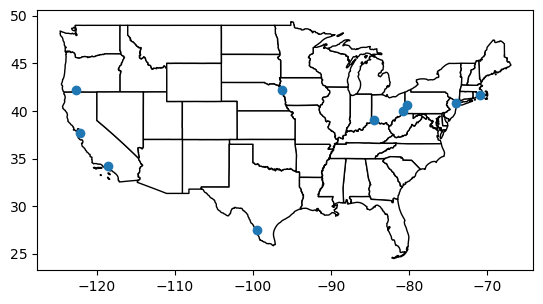

In [25]:
fig, axarr = plt.subplots()
states.plot(ax=axarr, color='white', edgecolor='black')
tract_performance_stats.sort_values('corr').head(10).centroid.plot(ax=axarr)

In [26]:
tract_performance_stats.sort_values('corr').head(10).to_file(f'corr_low_tracts_{version}.shp')